<a href="https://colab.research.google.com/github/devanshsaroja/pfr-cstr-simulation/blob/main/Communication_System_2022UCH0047.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import butter, lfilter
from scipy.signal import butter, filtfilt

In [9]:
!ffmpeg -i "sample_voice.opus" voice.wav


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

# Part 1: Voice Signal Analysis
#Load recorded voice signal

In [12]:
fs, data = wavfile.read(r"voice.wav")

if len(data.shape) == 2:
    data = data.mean(axis=1)

duration = len(data) / sample_rate
time = np.linspace(0., duration, len(data))

#Time-domain plot

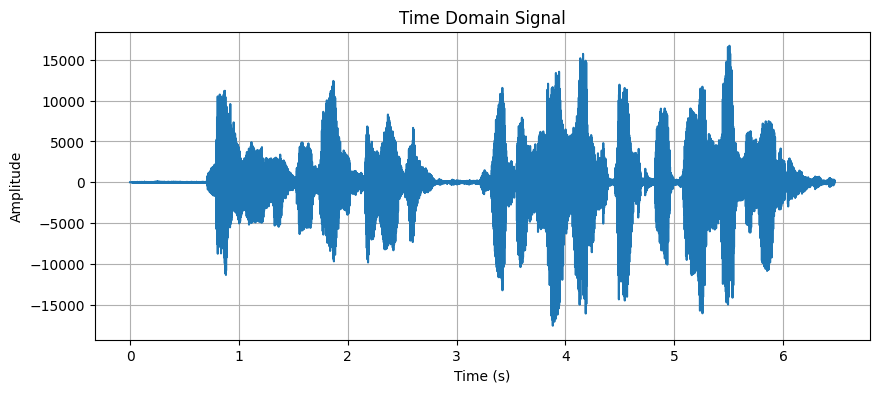

In [13]:
t = np.arange(len(data)) / fs
plt.figure(figsize=(10, 4))
plt.plot(t, data)
plt.title('Time Domain Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

# Frequency-domain analysis

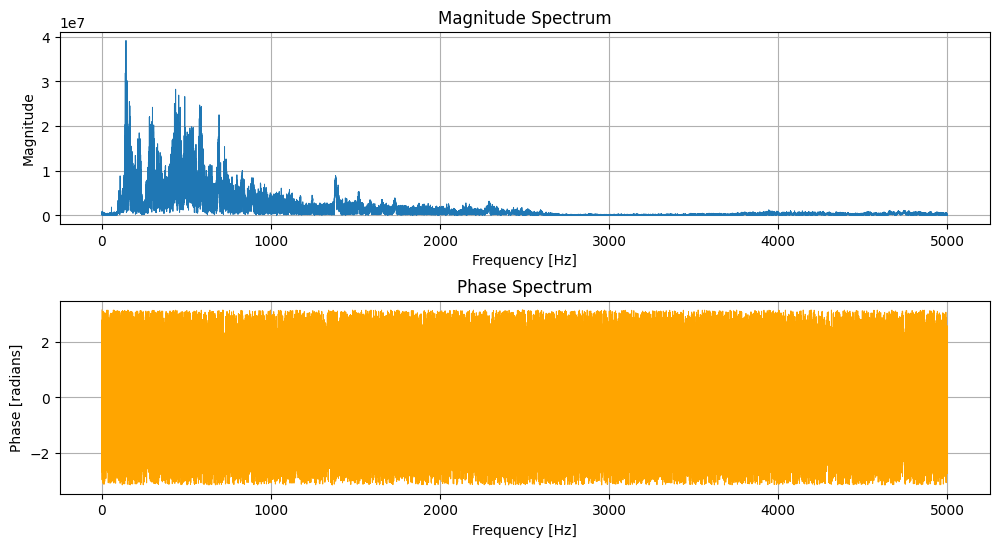

In [14]:
N = len(data)

fft_result = np.fft.fft(data)
freqs = np.fft.fftfreq(N, d=1/sample_rate)

pos_mask = freqs >= 0
freqs = freqs[pos_mask]
magnitude = np.abs(fft_result[pos_mask])
phase = np.angle(fft_result[pos_mask])

limit_mask = freqs <= 5000
freqs = freqs[limit_mask]
magnitude = magnitude[limit_mask]
phase = phase[limit_mask]

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

# Magnitude Spectrum
axs[0].plot(freqs, magnitude, linewidth=0.7)
axs[0].set_title("Magnitude Spectrum")
axs[0].set_ylabel("Magnitude")
axs[0].set_xlabel("Frequency [Hz]")  # this will now show
axs[0].grid(True)

# Phase Spectrum
axs[1].plot(freqs, phase, linewidth=0.7, color='orange')
axs[1].set_title("Phase Spectrum")
axs[1].set_xlabel("Frequency [Hz]")
axs[1].set_ylabel("Phase [radians]")
axs[1].grid(True)

plt.subplots_adjust(hspace=0.4)
plt.show()


# Determine bandwidth


Estimated Voice Bandwidth: 1632.35 Hz
Frequency Range: 99.95 Hz to 1732.29 Hz


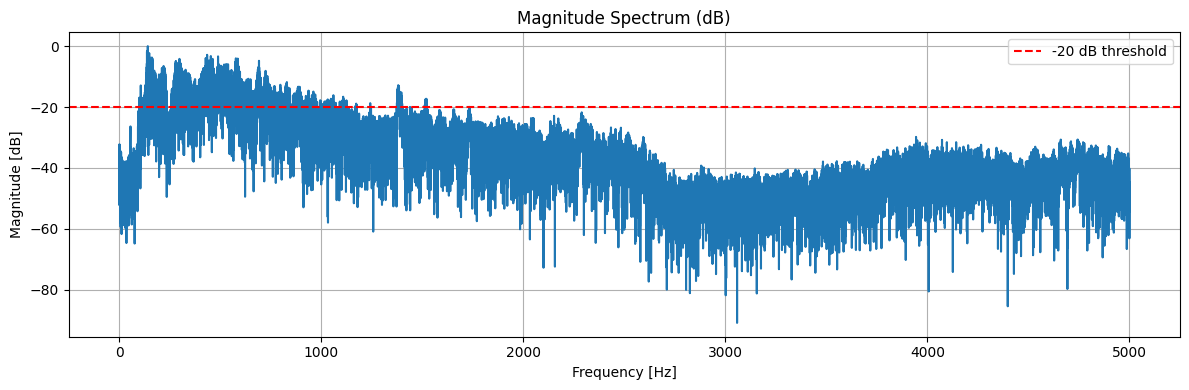

In [16]:
magnitude_db = 20 * np.log10(magnitude / np.max(magnitude))

threshold_db = -20# You can adjust this

significant_freqs = freqs[magnitude_db > threshold_db]

bandwidth = significant_freqs[-1] - significant_freqs[0]
lower_freq = significant_freqs[0]
upper_freq = significant_freqs[-1]

print(f"Estimated Voice Bandwidth: {bandwidth:.2f} Hz")
print(f"Frequency Range: {lower_freq:.2f} Hz to {upper_freq:.2f} Hz")

plt.figure(figsize=(12, 4))
plt.plot(freqs, magnitude_db)
plt.axhline(y=threshold_db, color='red', linestyle='--', label=f'{threshold_db} dB threshold')
plt.title("Magnitude Spectrum (dB)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
freqs = np.fft.fftfreq(N, d=1/sample_rate)

mask = freqs >= 0
freqs = freqs[mask]
fft_magnitude = np.abs(fft_result[mask])
fft_magnitude_db = 20 * np.log10(fft_magnitude / np.max(fft_magnitude))

carrier_index = np.argmax(fft_magnitude)
carrier_freq = freqs[carrier_index]

threshold_db = -40
significant_freqs = freqs[fft_magnitude_db > threshold_db]
bandwidth = significant_freqs[-1] - significant_freqs[0]
lower_freq = significant_freqs[0]
upper_freq = significant_freqs[-1]

print(f"Dominant Frequency ≈ {carrier_freq:.2f} Hz")
print(f"Estimated Modulated Bandwidth ≈ {bandwidth:.2f} Hz")
print(f"Sideband Frequency Range ≈ {lower_freq:.2f} Hz to {upper_freq:.2f} Hz")

Dominant Frequency ≈ 142.27 Hz
Estimated Modulated Bandwidth ≈ 6336.29 Hz
Sideband Frequency Range ≈ 0.31 Hz to 6336.60 Hz


# Part 2: AM Modulation and Demodulation


In [41]:
A_m = np.max(np.abs(data))  # Maximum absolute value

A_c = 1  # Normalized peak amplitude of carrier

 # Maximum message signal frequency in Hz



print(f"Amplitude of the message signal (A_m): {A_m}")
print(f"Peak amplitude of the carrier (A_c): {A_c}")


Amplitude of the message signal (A_m): 17569
Peak amplitude of the carrier (A_c): 1


In [40]:
def find_max_frequency(signal, sample_rate):
    n = len(signal)
    fft_result = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(n, 1/sample_rate)

    # Get only positive frequencies
    positive_freq = frequencies[:n//2]
    fft_magnitude = np.abs(fft_result[:n//2])

    # Find the highest significant frequency (ignore DC and noise)
    threshold = 0.1 * np.max(fft_magnitude)  # 10% of peak as threshold
    significant_freqs = positive_freq[fft_magnitude > threshold]
    f_m = np.max(significant_freqs)

    return f_m
f_m = find_max_frequency(data, fs)
print(f"Highest voice frequency component: {f_m/1000:.2f} kHz")
print(f"Estimated AM bandwidth: {2*f_m/1000:.2f} kHz")

Highest voice frequency component: 1.73 kHz
Estimated AM bandwidth: 3.46 kHz


Estimated Bandwidth: 1379.93357534564 Hz


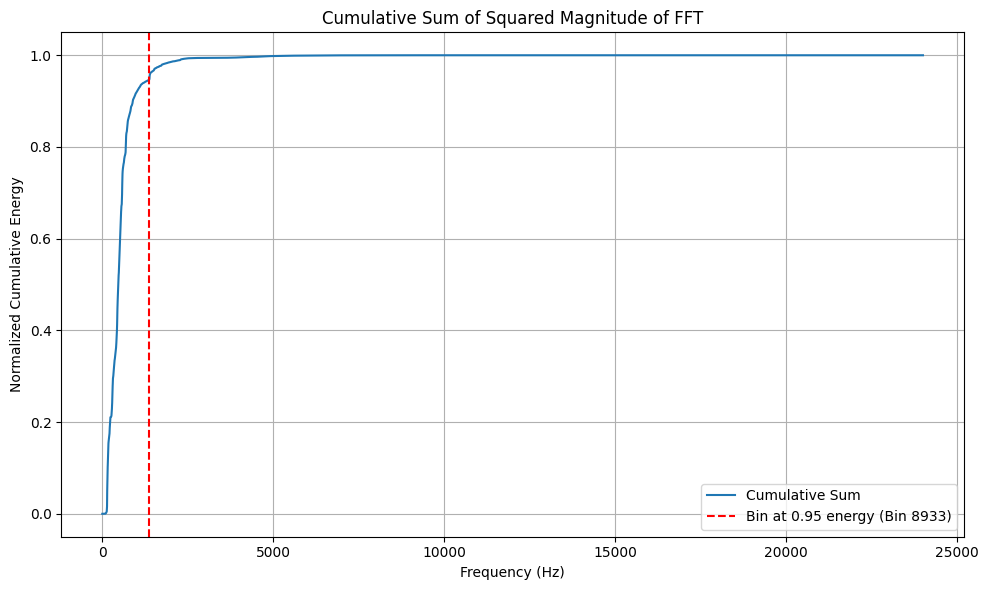

In [42]:
fft_signal = np.fft.rfft(data)  # Real FFT (only positive frequencies)
fft_magnitude = np.abs(fft_signal)  # Magnitude of FFT

squared_magnitude = np.square(fft_magnitude)

cumulative_sum = np.cumsum(squared_magnitude)

total_energy = cumulative_sum[-1]  # Energy in the signal
normalized_cumulative_sum = cumulative_sum / total_energy

target_energy = 0.95
bin_index = np.where(normalized_cumulative_sum >= target_energy)[0][0]

bandwidth = bin_index / N * fs

print(f"Estimated Bandwidth: {bandwidth} Hz")

plt.figure(figsize=(10, 6))

freq_bins = np.linspace(0, fs / 2, len(squared_magnitude))

plt.plot(freq_bins, normalized_cumulative_sum, label="Cumulative Sum")
plt.axvline(freq_bins[bin_index], color='r', linestyle='--', label=f"Bin at 0.95 energy (Bin {bin_index})")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Cumulative Energy")
plt.title("Cumulative Sum of Squared Magnitude of FFT")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Modulated signal time-domain


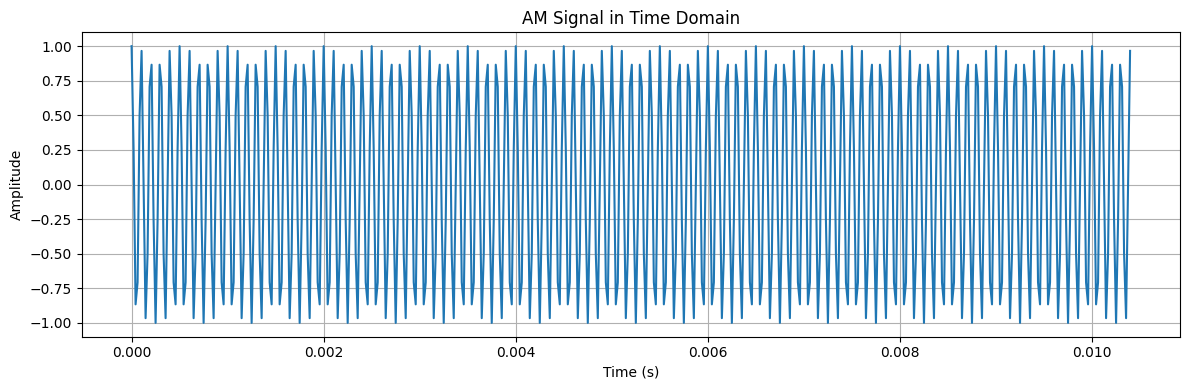

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Step 1: Load message signal
fs, message = wavfile.read(r"/content/voice.wav")  # fs = sampling frequency

# Convert to mono if stereo
if len(message.shape) == 2:
    message = message.mean(axis=1)

# Normalize message signal (optional: to keep modulation depth within bounds)
message = message / np.max(np.abs(message))  # Now -1 ≤ m(t) ≤ 1

# Step 2: Define parameters
mu = 0.5               # Modulation index
A_c = 1.0               # Carrier amplitude (you can use A_c = A_m if known)
f_c = 10000             # Carrier frequency in Hz (10 kHz)

# Step 3: Generate time vector
t = np.arange(len(message)) / fs

# Step 4: Generate AM signal
am_signal = A_c * (1 + mu * message) * np.cos(2 * np.pi * f_c * t)

# Step 5: Plot
plt.figure(figsize=(12, 4))
plt.plot(t[:500], am_signal[:500])  # Show only a small segment for clarity
plt.title("AM Signal in Time Domain")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

# Modulated signal frequency-domain

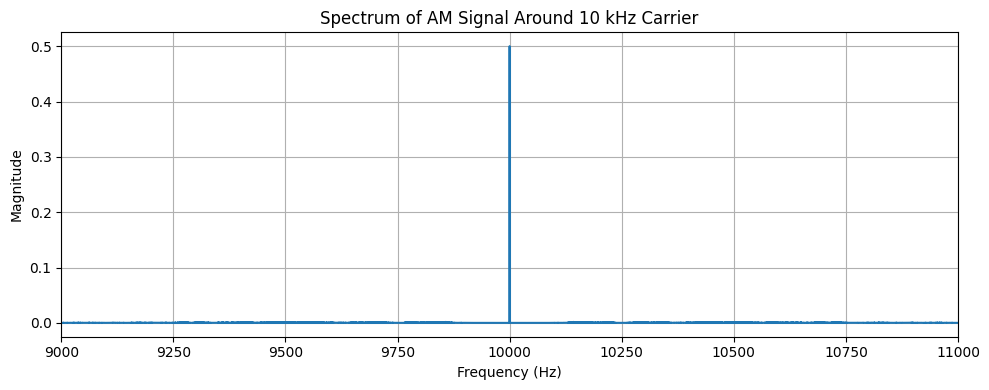

In [31]:
N = len(am_signal)
fft_am = np.fft.fft(am_signal)
fft_am = np.abs(fft_am) / N  # Normalize

# Frequency axis
freqs = np.fft.fftfreq(N, d=1/fs)

# Use only positive frequencies
half_N = N // 2
fft_am = fft_am[:half_N]
freqs = freqs[:half_N]

# Plot zoomed in around 10 kHz
plt.figure(figsize=(10, 4))
plt.plot(freqs, fft_am)
plt.xlim(9000, 11000)  # Zoom window around 10 kHz
plt.title("Spectrum of AM Signal Around 10 kHz Carrier")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
rectified = np.abs(am_signal)

def lowpass_filter(signal, cutoff_freq, fs, order=5):
    nyq = 0.5 * fs
    norm_cutoff = cutoff_freq / nyq
    b, a = butter(order, norm_cutoff, btype='low')
    return filtfilt(b, a, signal)

cutoff = 1000  # Hz
demodulated = lowpass_filter(rectified, cutoff, fs)
demodulated -= np.mean(demodulated)
message_norm = message / np.max(np.abs(message))
demodulated_norm = demodulated / np.max(np.abs(demodulated))

# Plot demodulated vs original


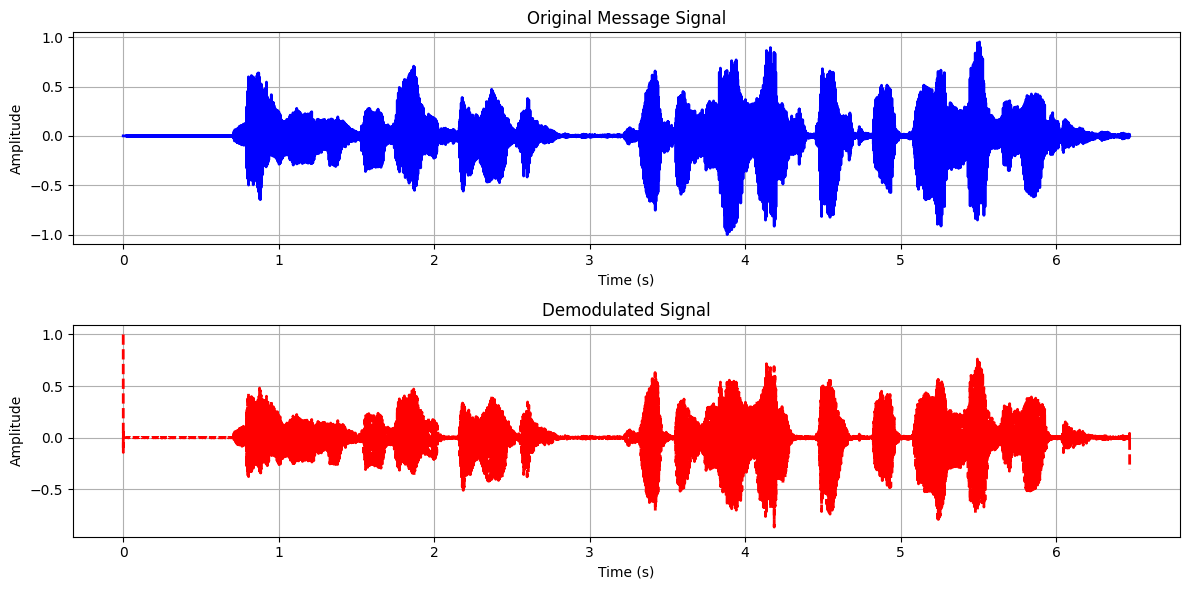

In [35]:
plt.figure(figsize=(12, 6))

# Original message signal
plt.subplot(2, 1, 1)
plt.plot(t, message_norm, color='blue', linewidth=2)
plt.title("Original Message Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)

# Demodulated signal
plt.subplot(2, 1, 2)
plt.plot(t, demodulated_norm, color='red', linestyle='--', linewidth=2)
plt.title("Demodulated Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()
